<a href="https://colab.research.google.com/github/jihyuk1023/AI_physics/blob/main/4_2_Regularization_and_Hyperparameter_Tuning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from abc import *
import sys
import tqdm
import joblib

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1,784)

x_val = x_train[54000:]
y_val_encoded = y_train_encoded[54000:]
x_train = x_train[:54000]
y_train_encoded = y_train_encoded[:54000]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def sigmoid(x):
  return 1 / (1+np.exp(-x))

  
def softmax(array):
  return np.exp(array) / np.sum(np.exp(array), axis = 1)

In [ ]:
class layer():
  '''
  layer class. Dense층을 형성합니다.
  '''
  def __init__(self, n_neuron):
    self.n_neuron = n_neuron

In [ ]:
class FCNet():
  '''
  Fully Connected net 을 생성합니다.
  '''
  def __init__(self):
    self.layers = []
    super().__init__()

  def append_layer(self, n_neuron):
    self.layers.append(layer(n_neuron)) #layer object들을 추가합니다. layer object는 n_neuron을 그 속성으로 가집니다. 따라서, model.append_layer(300)은 뉴런의 개수가 300개인 레이어가 모델에 추가됩니다.

  def compile(self, weight_mode = 'normal'):
    if weight_mode not in ['ones', 'zeros', 'normal', 'uniform']:
      print("weight mode should be one of the 'ones', 'zeros', 'normal', 'uniform'")
      sys.exit()
    self.weight = [] # 각 층의 weight를 담을 리스트를 생성합니다.
    self.bias = [] # 각 층의 bias를 담을 리스트를 생성합니다.
    self.len_layers = len(self.layers) # layer의 개수를 의미합니다. 
    for i in range(self.len_layers - 1): # weight, bias는 각 층의 연결시에 필요하므로 그 개수는 레이어 개수보다 한 개 적습니다.
      if weight_mode == 'normal':
        W = np.random.normal(0, 1, (self.layers[i].n_neuron, self.layers[i+1].n_neuron)) # 각 층의 weight는 [입력층 뉴런 수, 출력층 뉴런 수]의 파라미터를 가집니다.
        b = np.random.normal(0, 1, (self.layers[i+1].n_neuron)) # 각 층의 bias는 [출력층 뉴런수]개의 파라미터를 가집니다.
      if weight_mode == 'uniform':
        W = np.random.uniform(0, 1, (self.layers[i].n_neuron, self.layers[i+1].n_neuron)) # 각 층의 weight는 [입력층 뉴런 수, 출력층 뉴런 수]의 파라미터를 가집니다.
        b = np.random.uniform(0, 1, (self.layers[i+1].n_neuron)) # 각 층의 bias는 [출력층 뉴런수]개의 파라미터를 가집니다.
      if weight_mode == 'zeros':
        W = np.zeros((self.layers[i].n_neuron, self.layers[i+1].n_neuron)) # 각 층의 weight는 [입력층 뉴런 수, 출력층 뉴런 수]의 파라미터를 가집니다.
        b = np.zeros((self.layers[i+1].n_neuron)) # 각 층의 bias는 [출력층 뉴런수]개의 파라미터를 가집니다.
      if weight_mode == 'ones':
        W = np.ones((self.layers[i].n_neuron, self.layers[i+1].n_neuron)) # 각 층의 weight는 [입력층 뉴런 수, 출력층 뉴런 수]의 파라미터를 가집니다.
        b = np.ones((self.layers[i+1].n_neuron)) # 각 층의 bias는 [출력층 뉴런수]개의 파라미터를 가집니다.
      self.weight.append(W) # 리스트에 weight를 저장합니다.
      self.bias.append(b)
    self.compiled = True

  def forward(self, batch):
    self.layer_outputs = [batch] # layer_outputs를 생성합니다. 이는 각 출력층의 값들입니다. 첫 번째 원소는 input이여야 하므로, 입력받은 batch를 이미 리스트로 가지고 있습니다.
    for index, (weight, bias) in enumerate(zip(self.weight, self.bias)): # enumerate 함수는 index, object를, zip 함수는 두 object를 동시에 호출하는 함수입니다.
      new_batch = np.dot(batch, weight) + bias # 다음 층의 출력을 계산합니다. Wx + b
      new_batch = sigmoid(new_batch) # activation 함수를 통과시킵니다.
      if index == self.len_layers - 1: # 마지막 층에서는 
        new_batch = softmax(new_batch) # softmax함수에 통과시킵니다.(전체 확률은 1이 됩니다.)
      batch = new_batch # 다음 층에도 이를 통과시키기 위해 batch를 new_batch로 변경합니다.
      self.layer_outputs.append(batch) # layer_outputs에 출력층의 값을 추가해줍니다.

  def loss(self, prediction, output): # Cross entropy 값을 loss로 갖는 함수입니다.
    cross_entropy = - (np.sum(output * np.log(prediction) + (1-output) * np.log(1-prediction))) / len(output)
    return cross_entropy

  def backpropagation(self, output): 
    self.weight_grad = [] # weight의 기울기 리스트를 생성합니다.
    self.bias_grad = []# bias의 기울기 리스트를 생성합니다.
    for idx in range(self.len_layers - 1): # 인덱싱이 복잡합니다. 역전파 이므로 순서가 반대입니다.
      if idx == 0: # 마지막 층 인덱스에서
        dC_ds = self.layer_outputs[-1] - output # dC/ds 는 (x_k - t_k) 2 * (asdfasdf)
      else: # 나머지 층에서
        x = self.layer_outputs[-(idx+1)]
        dx_ds = x * (1 - x) # dx/ds 는 sigmoid의 미분 x(1-x)입니다.z
        dC_ds = dC_ds @ self.weight[-(idx)].T * dx_ds # dC/dsj = dC/dsk * dsk/dxj * dxj/dsj 
      ds_dw = self.layer_outputs[-(idx+2)] # dsj/dwj는 항상 그 이전층 xi입니다.
      dC_dw = (dC_ds.reshape(self.batch_size, -1, 1) @ ds_dw.reshape(self.batch_size, 1,-1)).T #dC_dw = dC/ds * ds/dw
      dC_db = dC_ds # ds/db = 1 입니다.
      dC_dw = np.mean(dC_dw, axis = 2) # 각 batch의 cost function은 원래 cost function의 평균값입니다.
      dC_db = np.mean(dC_db, axis = 0) 
      self.weight_grad.append(dC_dw) # weight grad 리스트에 weight의 기울기를 추가합니다.
      self.bias_grad.append(dC_db)
    self.weight_grad = self.weight_grad[::-1] #오차 역전파는 반대방향이므로, 방향을 통일하기 위해 뒤집습니다.
    self.bias_grad = self.bias_grad[::-1]
  
  def accuracy(self, predict, output):
    return np.where(np.argmax(predict, axis = 1) == np.argmax(output, axis=1), 1,0).sum() / len(output)

  def validation(self, validation_input, validation_output):
    self.forward(validation_input)
    predict = self.layer_outputs[-1]
    acc = self.accuracy(predict, validation_output)
    loss = self.loss(predict, validation_output)
    print("")
    print('val_accuracy = {}'.format(acc))
    print('val_loss = {}'.format(loss))

  def fit(self, x, y, val_x, val_y, epochs, batch_size, lr = 0.1, lambda_1 = 0.001, lambda_2 =0.1):
    self.batch_size = batch_size
    self.val_loss_history = []
    self.val_acc_history = []
    self.train_loss_history = []
    self.train_acc_history = []
    self.trainer = True
    if self.trainer:
      for epoch in range(epochs):
        train_loss = 0
        train_acc = 0
        batch_generator = self.batch_generator(x, y, self.batch_size) # batch를 생성할 수 있는 generator를 생성합니다. 제너레이터는 데이터들을 호출합니다.
        steps = len(x) // batch_size 
        for i in tqdm.tqdm(range(steps)): # batch의 개수입니다. tqdm module은 상태 바를 만들어줍니다. 진행 상황을 확인할 수 있습니다.
          batch, batch_output = next(batch_generator)
          self.forward(batch) # batch를 이용하여 데이터를 예측합니다.
          self.backpropagation(batch_output) # 오차 역전파를 진행합니다.
          for i in range(self.len_layers - 1): 
            self.weight[i] = (1 - lr * lambda_2 / len(batch)) * self.weight[i] - lr * self.weight_grad[i] - lr * lambda_1 * np.sign(self.weight[i]) # weight를 업데이트 합니다. weight_grad 값에 스칼라를 곱해 이 속도를 조절할 수 있습니다.
            self.bias[i] = self.bias[i] - lr *self.bias_grad[i] # bias를 업데이트 합니다. 
          train_loss += self.loss(self.layer_outputs[-1], batch_output)
          train_acc += self.accuracy(self.layer_outputs[-1], batch_output)
        train_loss /= steps
        train_acc /= steps
        self.train_loss_history.append(train_loss)    
        self.train_acc_history.append(train_acc)
        print("train_loss : {}".format(train_loss))
        print("train_acc : {}".format(train_acc))
        self.validation(val_x, val_y)
        self.early_stopping(5)


  def batch_generator(self, x, y , batch_size): # batch generator를 정의합니다. 
    i = -1
    while True:
      i += 1
      if (i+2)*batch_size < len(x):
        yield x[i*batch_size:(i+1)*batch_size], y[i*batch_size:(i+1)*batch_size]
      else:
        self.batch_size = len(x[i*batch_size:])
        yield x[i*batch_size:], y[i*batch_size:]
        i = -1
        self.batch_size = batch_size

  def validation(self, validation_input, validation_output):
    self.forward(validation_input)
    predict = self.layer_outputs[-1]
    acc = self.accuracy(predict, validation_output)
    loss = self.loss(predict, validation_output)
    self.val_loss_history.append(loss)
    self.val_acc_history.append(acc)
    print('\nval_loss = {}'.format(loss))
    print('val_accuracy = {}'.format(acc))

  def plot_graph(self):
    plt.style.use('ggplot')
    mpl.rcParams['axes.unicode_minus'] = False
    
    fig, axes = plt.subplots(2,1)
    axes[0].plot(self.train_loss_history, label='train_loss')
    axes[0].plot(self.val_loss_history, label='test_loss')
    axes[0].title.set_text("loss graph")
    plt.legend()
    axes[1].plot(self.train_acc_history, label = 'train_acc')
    axes[1].plot(self.val_acc_history, label = 'val_acc')
    axes[1].title.set_text("acc graph")
    plt.legend()
    plt.show()

  def early_stopping(self, watch):
    best_history = np.argmax(self.val_acc_history)
    if best_history == len(self.val_acc_history) - watch:
      print("early stopped.")
      self.trainer = 0

In [ ]:
net = FCNet()
net.append_layer(784)
net.append_layer(256)
net.append_layer(10)
net.compile(weight_mode = 'normal')

In [ ]:
def savemodel(filename, model):        
  joblib.dump(model,filename)

In [ ]:
net.fit(x_train, y_train_encoded, x_test, y_test_encoded, 30, 64, lr= 0.1)
savemodel("/content/model_v0", net)

100%|██████████| 843/843 [01:12<00:00, 11.71it/s]


train_loss : 2.484935617255204
train_acc : 0.7080738434163701


  0%|          | 1/843 [00:00<02:00,  7.01it/s]


val_loss = 1.1488064731210599
val_accuracy = 0.8425


100%|██████████| 843/843 [01:59<00:00,  7.08it/s]


train_loss : 0.984865377739646
train_acc : 0.863158786646332


  0%|          | 1/843 [00:00<01:58,  7.09it/s]


val_loss = 0.8118932512764022
val_accuracy = 0.8865


100%|██████████| 843/843 [01:59<00:00,  7.07it/s]


train_loss : 0.7698794225932426
train_acc : 0.8924189226402307


  0%|          | 1/843 [00:00<01:57,  7.16it/s]


val_loss = 0.6910547408607155
val_accuracy = 0.904


100%|██████████| 843/843 [01:58<00:00,  7.09it/s]


train_loss : 0.6870976858473283
train_acc : 0.906281774275547


  0%|          | 1/843 [00:00<02:00,  7.00it/s]


val_loss = 0.6441125028737414
val_accuracy = 0.9152


100%|██████████| 843/843 [01:59<00:00,  7.08it/s]


train_loss : 0.6614102944505041
train_acc : 0.9135885337230988


  0%|          | 1/843 [00:00<01:58,  7.12it/s]


val_loss = 0.6362352957431352
val_accuracy = 0.9197


100%|██████████| 843/843 [01:58<00:00,  7.09it/s]


train_loss : 0.6668064228831336
train_acc : 0.9160894339942376


  0%|          | 1/843 [00:00<02:07,  6.62it/s]


val_loss = 0.6517492688311508
val_accuracy = 0.9209


100%|██████████| 843/843 [01:58<00:00,  7.09it/s]


train_loss : 0.6905190911849255
train_acc : 0.9151070793085917


  0%|          | 1/843 [00:00<01:59,  7.02it/s]


val_loss = 0.6816958665309448
val_accuracy = 0.9201


100%|██████████| 843/843 [01:59<00:00,  7.08it/s]


train_loss : 0.7265481718068649
train_acc : 0.9126326576004056


  0%|          | 1/843 [00:00<01:57,  7.18it/s]


val_loss = 0.721516906267865
val_accuracy = 0.916


100%|██████████| 843/843 [01:59<00:00,  7.06it/s]


train_loss : 0.7732763789912558
train_acc : 0.9079591912387728


  0%|          | 1/843 [00:00<01:57,  7.16it/s]


val_loss = 0.7704537596602293
val_accuracy = 0.9116


100%|██████████| 843/843 [02:00<00:00,  6.99it/s]


train_loss : 0.8271718035109036
train_acc : 0.9020809502626675


  0%|          | 1/843 [00:00<01:58,  7.10it/s]


val_loss = 0.8239319120438162
val_accuracy = 0.9056
early stopped.


100%|██████████| 843/843 [02:01<00:00,  6.96it/s]


train_loss : 0.8823771732863857
train_acc : 0.8954944077275044


  0%|          | 1/843 [00:00<01:56,  7.22it/s]


val_loss = 0.8759422407948178
val_accuracy = 0.9005


100%|██████████| 843/843 [02:00<00:00,  6.98it/s]


train_loss : 0.9289353616487558
train_acc : 0.8899339095068636


  0%|          | 1/843 [00:00<01:57,  7.15it/s]


val_loss = 0.9144656623999446
val_accuracy = 0.8944


100%|██████████| 843/843 [02:01<00:00,  6.96it/s]


train_loss : 0.9573127207890539
train_acc : 0.8861223203694288


  0%|          | 1/843 [00:00<02:01,  6.91it/s]


val_loss = 0.9318393310949946
val_accuracy = 0.8911


100%|██████████| 843/843 [02:01<00:00,  6.96it/s]


train_loss : 0.9642283456689505
train_acc : 0.884143047788511


  0%|          | 1/843 [00:00<02:00,  6.96it/s]


val_loss = 0.9290440135871176
val_accuracy = 0.8905


100%|██████████| 843/843 [02:01<00:00,  6.95it/s]


train_loss : 0.955863406118214
train_acc : 0.8832507202169129


  0%|          | 1/843 [00:00<01:58,  7.12it/s]


val_loss = 0.9150177389295066
val_accuracy = 0.8911


100%|██████████| 843/843 [02:04<00:00,  6.79it/s]


train_loss : 0.9394073549545383
train_acc : 0.8838544314522967


  0%|          | 1/843 [00:00<02:04,  6.74it/s]


val_loss = 0.8965539443367581
val_accuracy = 0.8923


100%|██████████| 843/843 [02:04<00:00,  6.77it/s]


train_loss : 0.9206198261875647
train_acc : 0.8852524995763434


  0%|          | 1/843 [00:00<02:06,  6.66it/s]


val_loss = 0.8786070543249341
val_accuracy = 0.8942


100%|██████████| 843/843 [02:03<00:00,  6.85it/s]


train_loss : 0.9026458015999221
train_acc : 0.8872834053550251


  0%|          | 1/843 [00:00<02:00,  6.99it/s]


val_loss = 0.8619849463186685
val_accuracy = 0.8961


100%|██████████| 843/843 [02:03<00:00,  6.85it/s]


train_loss : 0.8863008967704528
train_acc : 0.8889250762582623


  0%|          | 1/843 [00:00<02:01,  6.94it/s]


val_loss = 0.8472018776331295
val_accuracy = 0.8973


100%|██████████| 843/843 [02:03<00:00,  6.84it/s]


train_loss : 0.8719739892915838
train_acc : 0.8905031986104053


  0%|          | 1/843 [00:00<02:07,  6.59it/s]


val_loss = 0.8345012896604316
val_accuracy = 0.8986


100%|██████████| 843/843 [02:02<00:00,  6.89it/s]


train_loss : 0.8596468438460634
train_acc : 0.892004533129978


  0%|          | 1/843 [00:00<02:00,  6.98it/s]


val_loss = 0.8233498516289457
val_accuracy = 0.9002


100%|██████████| 843/843 [02:01<00:00,  6.91it/s]


train_loss : 0.8488538155362484
train_acc : 0.8932755041518391


  0%|          | 1/843 [00:00<02:01,  6.94it/s]


val_loss = 0.8136481525466752
val_accuracy = 0.9008


100%|██████████| 843/843 [02:02<00:00,  6.89it/s]


train_loss : 0.8392465688593812
train_acc : 0.8941863667175058


  0%|          | 1/843 [00:00<02:03,  6.84it/s]


val_loss = 0.8049307528577666
val_accuracy = 0.9018


100%|██████████| 843/843 [02:01<00:00,  6.92it/s]


train_loss : 0.8308309336312502
train_acc : 0.8948959922047119


  0%|          | 1/843 [00:00<02:02,  6.85it/s]


val_loss = 0.7974970518721629
val_accuracy = 0.9023


100%|██████████| 843/843 [02:01<00:00,  6.92it/s]


train_loss : 0.8236406849131179
train_acc : 0.895501027368244


  0%|          | 1/843 [00:00<02:01,  6.94it/s]


val_loss = 0.7911663360017234
val_accuracy = 0.9037


100%|██████████| 843/843 [02:02<00:00,  6.90it/s]


train_loss : 0.8173720622259097
train_acc : 0.8959352758007132


  0%|          | 1/843 [00:00<01:59,  7.04it/s]


val_loss = 0.7856631204753325
val_accuracy = 0.9042


100%|██████████| 843/843 [02:02<00:00,  6.87it/s]


train_loss : 0.8118113532855206
train_acc : 0.8965297195390624


  0%|          | 1/843 [00:00<02:00,  7.00it/s]


val_loss = 0.7807156549566374
val_accuracy = 0.904


100%|██████████| 843/843 [02:02<00:00,  6.85it/s]


train_loss : 0.8067587758979218
train_acc : 0.8974935392306397


  0%|          | 1/843 [00:00<02:01,  6.94it/s]


val_loss = 0.776245419887437
val_accuracy = 0.9046


100%|██████████| 843/843 [02:02<00:00,  6.89it/s]


train_loss : 0.8021793306626607
train_acc : 0.8981925732926629


  0%|          | 1/843 [00:00<01:57,  7.15it/s]


val_loss = 0.7722377261271101
val_accuracy = 0.9049


100%|██████████| 843/843 [02:02<00:00,  6.89it/s]


train_loss : 0.7980583465048672
train_acc : 0.8987221445517712

val_loss = 0.7686856405549451
val_accuracy = 0.9053


AttributeError: ignored

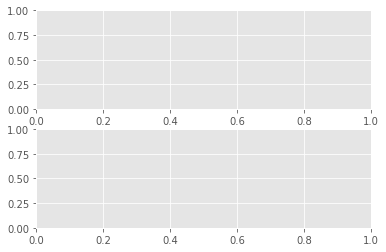

In [ ]:
savemodel("/content/model_v0", net)

net.plot_graph()